In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from tqdm import tqdm

## 데이터 불러오기

In [2]:
raw_data=pd.read_csv('./data09/funda_train.csv')
data=raw_data.copy()
data.info()
#data.describe()  
# 날짜 헷갈리니까 합친다.
# 환불 금액이 보임. 환불을 먼저 없앤다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


## 데이터 기본정보

In [3]:
num_store=len(data.store_id.unique())
num_card=len(data.card_company.unique())
num_region=len(data.region.unique())
num_business=len(data.type_of_business.unique())
num_installment=len(data.installment_term.unique())

print(f'store_id : {num_store}')
print(f'card_company : {num_card}')
print(f'region : {num_region}')
print(f'type_of_business : {num_business}')
print(f'installment_term : {num_installment}',end='\n')

data.info()

store_id : 1967
card_company : 8
region : 181
type_of_business : 146
installment_term : 34
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


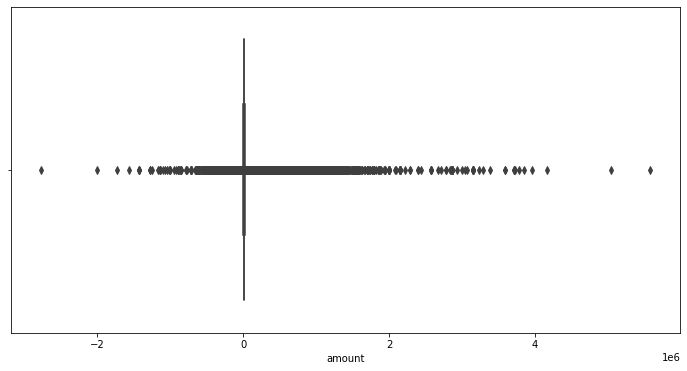

In [4]:
plt.figure(figsize=(12,6))
sns.boxplot(x='amount',data=data)

In [5]:
data.isna().sum()

print('region nan data :',(data.region.isna().sum()/len(data)).round(3))
print('type_of_business nan data :',(data.type_of_business.isna().sum()/len(data)).round(3))

region nan data : 0.312
type_of_business nan data : 0.603


1. 데이터 갯수가 60만개 이상 > 보통의 방법으로는 처리시간이 많이 걸림. > store_id로 나눠 생각한다.
2. transacted_date와 transacted_time 을 합쳐 datetime 형식으로 바꾼다. > 시계열 데이터 처리를 위한다.
3. 숫자형 데이터의 describe()를 봤을 때, amount의 음수가 있다.         > 환불 데이터는 후에 처리할 정보의 영향을 줄 수 있으므로 제거한다.
4. 시계열 데이터를 위해 월별 데이터를 모은다.  
5. 결측율이 region과 type_of_business 가 각각 30%와 60%를 넘어가며, 채우는데 더 오랜 시간이 걸릴걸로 보아 제거한다. 

## 환불금액 제거.

In [ ]:
#합치기
data['date']=data['transacted_date']+' '+data['transacted_time']
data['date']=pd.to_datetime(data['date'])
#환불 제거
data_neg=data[data['amount']<0]
data_pos=data[data['amount']>0]
remove_data=pd.DataFrame()
# store_id 안나누고 하니까 시간이 너무 오래걸림. 
for i in tqdm(data.store_id.unique()):
    divided_data=data_pos[data_pos['store_id']==i] 
    divided_data2=data_neg[data_neg['store_id']==i] 
    #행 마다 조사.    
    for neg in divided_data2.to_records():  
        refund_store=neg['store_id']
        refund_id=neg['card_id'] 
        refund_date=neg['date']
        refund_amount=abs(neg['amount'])
        #행뽑기
        row=divided_data[divided_data['date']<=refund_date]
        row=row[row['card_id']==refund_id]
        row=row[row['amount']==refund_amount]
        
        if(len(row)!=0):
            refund_date=max(row['date']) 
            remove=divided_data[divided_data['date']==refund_date] 
            remove=remove[remove['card_id']==refund_id] 
            remove=remove[remove['amount']==refund_amount] 
            divided_data=divided_data.drop(index=remove.index) 

    remove_data=pd.concat([remove_data,divided_data],axis=0)

remove_data

#remove_data.to_csv('./data09/funda_remove_data.csv')

In [6]:
data=pd.read_csv('./data09/funda_remove_data.csv',index_col=0)
data['date_slice']=pd.to_datetime(data['date'].str.slice(stop=10))
data=data.set_index('date_slice')
#data.head(3)

C:\Users\ckdck\miniconda3\envs\tensor\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


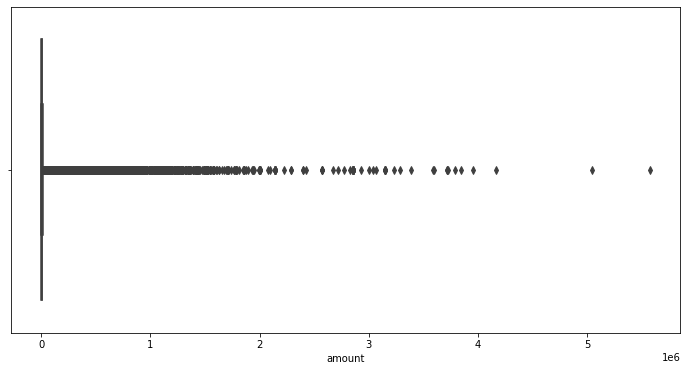

In [7]:
plt.figure(figsize=(12,6))
sns.boxplot(x='amount',data=data)

### 지성민님의 코드를 이해하며, 스스로 공부하는 뜻으로, 중요한 부분은 amount 다.
### 제일 중요한 부분은 월별로 amount의 합을 모으는 것이다. 

#### 요약본

In [ ]:
data_month=pd.DataFrame()
for i in tqdm(data.store_id.unique()):
    data_num=data[data.store_id==i]
    sum_amount=data_num['amount'].resample(rule='m').sum()
    data_mon=pd.concat([sum_amount],axis=1)
    data_mon.insert(0,'store_id',i)
    data_month=pd.concat([data_month,data_mon],axis=0)
    
data_month.head(10)

## 다시 이부분은 지성민님의 코드다.

#### 이 부분은 회귀를 위해 이렇게 진행하는 것이다.

In [ ]:
# 일 단위
data_day = pd.DataFrame()
# 똑같이 store_id 별로 나눈다.
for i in tqdm(data.store_id.unique()):
    data_num = data[data.store_id == i]
    #rule 'day' 
    count_cols = data_num['card_id'].resample(rule='d').count().rename('num_of_pay')
    # 재방문 인덱스 확인 
    #여기서 reset_index는 인덱스를 없애는게 아니라 새로운 인덱스를 만든다.
    revisit_idx = data_num.card_id.value_counts().reset_index().query("card_id > 2")["index"].values
    revisit_ct = data_num[data_num.card_id.isin(revisit_idx)].card_id.resample(rule='d').count().rename('num_of_revisit')
    # 할부 개월수와 매출액은 일 단위로 합
    sum_cols = data_num[['installment_term', 'amount']].resample(rule='d').sum() 
    #
    data_num_day = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)
    #
    data_num_day.insert(0, 'store_id', i)
    data_num_day.insert(4, 'region', data_num[data_num.store_id == i].region.unique()[0])
    data_num_day.insert(5, 'type_of_business', data_num[data_num.store_id == i].type_of_business.unique()[0])
    #
    data_day = pd.concat([data_day, data_num_day], axis=0)   
#요일 및 일하는 날,
data_day.insert(1, 'day_of_week', data_day.index.dayofweek)
data_day.insert(2, 'business_day', data_day.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)
data_day.num_of_revisit.fillna(0, inplace=True)

data_day
#data_day.to_csv('./data09/funda_day.csv')

In [8]:
data=pd.read_csv('./data09/funda_day.csv',index_col=0)

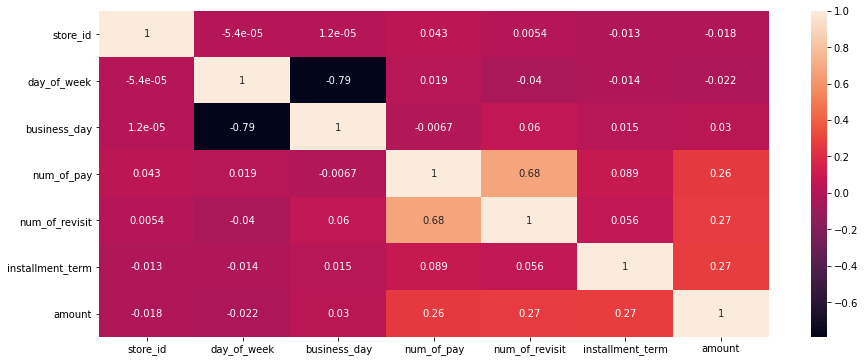

In [9]:
#상관관계 
plt.figure(figsize=(15,6))
sns.heatmap(data.corr(),annot=True)

In [ ]:
sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']
data_month = pd.DataFrame()

for i in tqdm(data.store_id.unique()):
    data_setting = data[data.store_id == i]

    tot_day = data_setting[data_setting.amount != 0].day_of_week.resample(rule='m').count().rename('real_tot_day')
    business = data_setting[data_setting.amount != 0].business_day.resample(rule='m').sum().rename('real_business_day')

    data_set = pd.concat([tot_day, business, data_setting[sum_cols].resample(rule='m').sum()], axis=1)

    data_set.insert(0, 'store_id', i)
    data_set.insert(6, 'region', data_setting.region.values[0])
    data_set.insert(7, 'type_of_business', data_setting.type_of_business.values[0])

    data_month = pd.concat([data_month, data_set], axis=0)

data_month
#data_month.to_csv('./data09/funda_month.csv')

In [10]:
data_month=pd.read_csv('./data09/funda_month.csv',index_col=0)

## EDA

Skewness : 0.48196370486124995


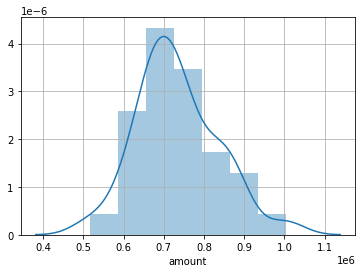

Skewness : 0.5102521050694732


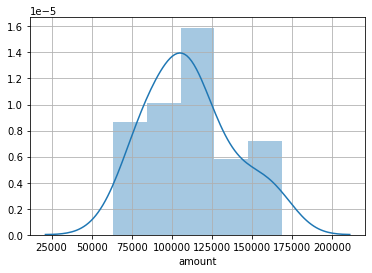

Skewness : 0.9982599271676977


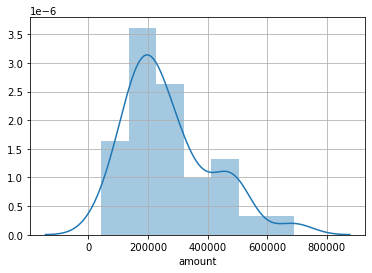

Skewness : 0.12011990320420246


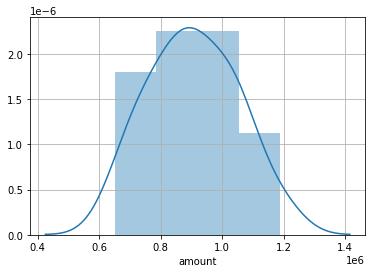

Skewness : 0.30687927390094477


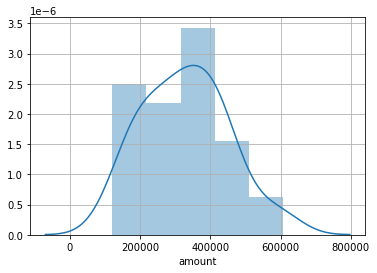

Skewness : 0.1133315714849039


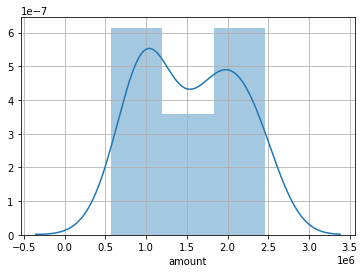

Skewness : 1.1817928313906387


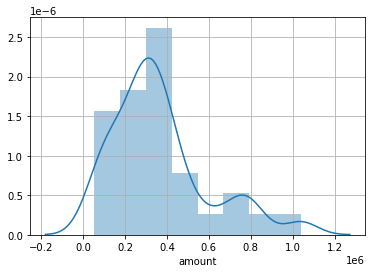

In [11]:
for i in data_month.store_id.unique()[:7]:
    print("Skewness :", data_month[data_month.store_id == i].amount.skew())
    sns.distplot(data_month[data_month.store_id == i].amount)
    plt.grid()
    plt.show()

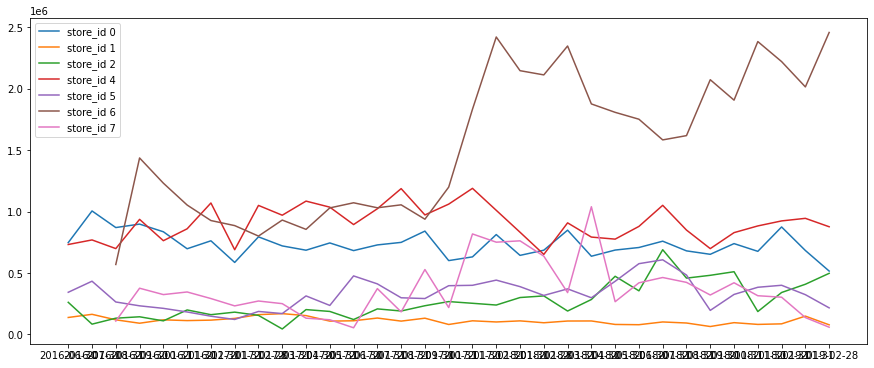

In [12]:
plt.figure(figsize=(15, 6))
for i in data_month.store_id.unique()[:7]:
    plt.plot(data_month[data_month.store_id == i].index, data_month[data_month.store_id == i].amount, label='store_id {}'.format(i))
plt.legend()

## 변동계수 와 boxcox

In [13]:
data_cv=pd.DataFrame(columns=['cv'])
for i in tqdm(data_month.store_id.unique()):
    data_num=data_month[data_month.store_id==i]
    cv=np.std(data_num.amount)/np.mean(data_num.amount)
    data_cv.loc[i,'cv']=cv

100%|█████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:05<00:00, 393.02it/s]


In [14]:
from scipy.stats import boxcox

data_month.amount=data_month.amount.apply(lambda x:x+2 if x==0.0 else x)
data_box=pd.DataFrame(columns=['optimal_lambda'])

for i in tqdm(data_month.store_id.unique()):
    sub_=data_month[data_month.store_id==i].amount
    _, l = boxcox(sub_)
    data_box.loc[i,'optimal_lambda']=l

100%|█████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:07<00:00, 260.57it/s]


In [15]:
data_an=pd.concat([data_cv,data_box],axis=1)
data_an

,cv,optimal_lambda
0,0.136249,-0.0557792
1,0.237716,-0.00245897
2,0.538133,0.2769
4,0.155397,0.51382
5,0.359291,0.552884
...,...,...
2132,0.233342,1.21089
2133,0.590344,0.558036
2134,0.632137,0.48475
2135,0.209097,0.259849


#### 이건 정확한 코드를 위해 정규화 할 척도를 잡는것이다. 

1. 처음 1등님 코드엔 cv<0.3 보다 낮을때 log를 해서 optimal_lambda 와 관계를 보려 했다. > 얻은 것은 없었다.
2. 일단, cv로 log 변환을 할 row를 택한다. 경우의 수 1번
3. 그리고 optimal_lambda로 log변환을 할지 제곱근변환을 할 row를 택한다. 경우의 수 2번.


## 단순 이동 평균

In [16]:
def plot_model_graph(data_frame, store_num, idx_col, y_cols):
    df_set = data_frame[data_frame.store_id == store_num]
    
    fig, ax1 = plt.subplots(figsize=(15, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.index, df_set[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.index, df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))

    fig.tight_layout()
    plt.show()

In [17]:
def sma(n):
    arr = np.array([])
    for i in data_month.store_id.unique():
        df_set = data_month[data_month.store_id == i]
        arr = np.concatenate((arr, df_set.amount.rolling(window=n,min_periods=1).mean().values))
        
    return arr

In [19]:
concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
df_sma=pd.DataFrame(columns=['store_id','amount'])

for i in data_month.store_id.unique():
    df_set = pd.DataFrame(data_month[data_month.store_id == i].amount)
    sma_train = pd.concat([df_set, concat_3mon], axis=0)
    num = df_set.amount.rolling(window=3,min_periods=1).mean().values[-3:].sum()
    df_sma.loc[i,'store_id']=i
    df_sma.loc[i,'amount']=num
#df_sma

,store_id,amount
0,0,2.19857e+06
1,1,295476
2,2,1.07186e+06
4,4,2.71067e+06
5,5,1.05059e+06
...,...,...
2132,2132,1.86462e+06
2133,2133,215235
2134,2134,267905
2135,2135,1.66124e+06


In [21]:
sma_month = data_month.copy()
sma_month.drop(['region','installment_term'],axis=1,inplace=True)

sma_month.insert(7, 'amount_2ma', sma(2))
sma_month.insert(8, 'amount_3ma', sma(3))
sma_month.insert(9, 'amount_6ma', sma(6))

#sma_month.tail()

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,type_of_business,amount,amount_2ma,amount_3ma,amount_6ma
2018-10-31,2136,31,23.0,332.0,77.0,기타 주점업,2.012214e+06,2.393964e+06,2.003410e+06,2.022026e+06
2018-11-30,2136,28,20.0,347.0,78.0,기타 주점업,2.127643e+06,2.069929e+06,2.305190e+06,2.010895e+06
2018-12-31,2136,31,21.0,397.0,101.0,기타 주점업,2.427429e+06,2.277536e+06,2.189095e+06,2.026633e+06
2019-01-31,2136,31,23.0,294.0,71.0,기타 주점업,1.867786e+06,2.147607e+06,2.140952e+06,2.072181e+06
2019-02-28,2136,28,20.0,366.0,69.0,기타 주점업,2.227429e+06,2.047607e+06,2.174214e+06,2.239702e+06


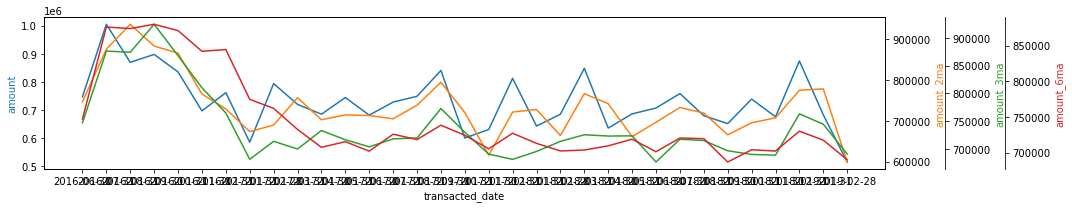

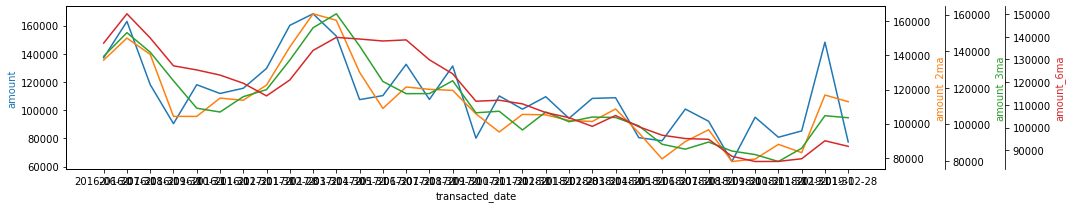

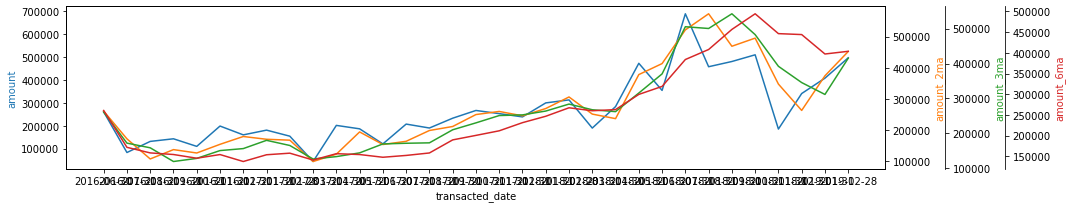

In [22]:
for i in sma_month.store_id.unique()[:3]:
    plot_model_graph(sma_month, i, 'transacted_date', ['amount', 'amount_2ma', 'amount_3ma', 'amount_6ma'])

In [23]:
from sklearn.metrics import mean_absolute_error as mae

print("2 winodw SMA MAE Score : ", mae(sma_month.amount_2ma, sma_month.amount.values))
print("3 window SMA MAE Score : ", mae(sma_month.amount_3ma, sma_month.amount.values))
print("6 window SMA MAE Score : ", mae(sma_month.amount_6ma, sma_month.amount.values))

2 winodw SMA MAE Score :  148730.67734030637
3 window SMA MAE Score :  188974.02932462253
6 window SMA MAE Score :  238951.5981297745


In [24]:
def sub(df,n):
    concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
    df_sma=pd.DataFrame(columns=['store_id','amount'])

    for i in data_month.store_id.unique():
        df_set = pd.DataFrame(df[df.store_id == i].amount)
        sma_train = pd.concat([df_set,concat_3mon], axis=0)
        num = df_set.amount.rolling(window=n,min_periods=1).mean().values[-3:].sum()
        df_sma.loc[i,'store_id']=i
        df_sma.loc[i,'amount']=num
        
    return df_sma

In [ ]:
for i in tqdm(range(4, 7)):
    sma_sub = sub(data_month, i)
    sma_sub.to_csv(f'./data09/funda_{i}sma_sub.csv',index=False)

## 지수 이동 평균

In [25]:
def ema(df,n):
    arr = np.array([])
    for i in df.store_id.unique():
        df_set = df[df.store_id == i]
        arr = np.concatenate((arr, df_set.amount.ewm(span=n).mean().values))
    
    return arr

In [26]:
ema_month = data_month.copy()
ema_month.drop(['region','installment_term'],axis=1,inplace=True)

ema_month.insert(7, 'amount_3ema', ema(ema_month, 3))
ema_month.insert(8, 'amount_6ema', ema(ema_month, 6))

#ema_month

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,type_of_business,amount,amount_3ema,amount_6ema
2016-06-30,0,25,17.0,143.0,74.0,기타 미용업,7.470000e+05,7.470000e+05,7.470000e+05
2016-07-31,0,26,16.0,178.0,105.0,기타 미용업,1.005000e+06,9.190000e+05,8.975000e+05
2016-08-31,0,24,16.0,168.0,94.0,기타 미용업,8.697143e+05,8.908367e+05,8.850092e+05
2016-09-30,0,25,19.0,160.0,103.0,기타 미용업,8.978571e+05,8.945810e+05,8.899718e+05
2016-10-31,0,26,16.0,165.0,115.0,기타 미용업,8.354286e+05,8.640507e+05,8.708287e+05
...,...,...,...,...,...,...,...,...,...
2018-10-31,2136,31,23.0,332.0,77.0,기타 주점업,2.012214e+06,2.094633e+06,2.086559e+06
2018-11-30,2136,28,20.0,347.0,78.0,기타 주점업,2.127643e+06,2.111138e+06,2.098317e+06
2018-12-31,2136,31,21.0,397.0,101.0,기타 주점업,2.427429e+06,2.269283e+06,2.192461e+06
2019-01-31,2136,31,23.0,294.0,71.0,기타 주점업,1.867786e+06,2.068534e+06,2.099618e+06


In [27]:
from sklearn.metrics import mean_absolute_error as mae

print("3 N EWM MAE Score : ", mae(ema_month.amount_3ema, sma_month.amount.values))
print("6 N EWM MAE Score : ", mae(ema_month.amount_6ema, sma_month.amount.values))

3 N EWM MAE Score :  134571.94619332795
6 N EWM MAE Score :  192971.60996871622


In [28]:
def sub(df,n):
    concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
    df_ema=pd.DataFrame(columns=['store_id','amount'])
    ema_sub = np.array([])

    for i in df.store_id.unique():
        df_set = pd.DataFrame(df[df.store_id == i].amount)
        ema_train = pd.concat([df_set, concat_3mon], axis=0)
        num_sub = ema_train.amount.ewm(span=n).mean()['2019-03':].sum()
        df_ema.loc[i,'store_id']=i
        df_ema.loc[i,'amount']=num_sub
        
    return df_ema

In [ ]:
for i in tqdm(range(4, 7)):
    ema_sub = sub(data_month, i)
    ema_sub.to_csv(f'./data09/funda_{i}ema_sub.csv',index=False)

## ACF, PACF

In [30]:
def time_series(data_month,i):
    ts=pd.Series(data_month[data_month.store_id==i].amount.values)
    return ts

C:\Users\ckdck\miniconda3\envs\tensor\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


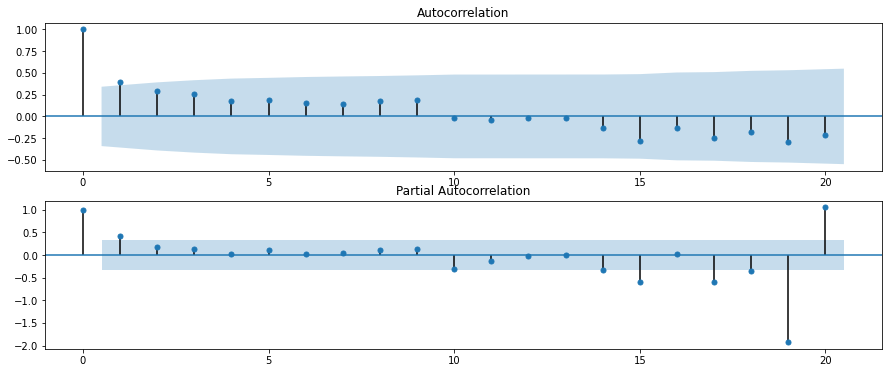

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

def acf_pacf_plot(data=None,store_id=None):
    ts=time_series(data,store_id)
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(211)
    plot_acf(ts,lags=20,ax=ax1)
    ax2 = fig.add_subplot(212)
    plot_pacf(ts, lags=20, ax=ax2)
    
acf_pacf_plot(data=data_month,store_id=1)

1. store_id = 1 인 경우 acf, pacf 로 부터 p = 0, q = 2 를 추정할 수 있다.
2. store_id = 6 인 경우 acf, pacf 로 부터 p = 1, q = 0 을 추정할 수 있다.

## ARIMA

In [32]:
import itertools

p = [0,1,2]
d = [0,1,2]
q = [0,1,2]

pdq = list(itertools.product(p, d, q))

In [36]:
from statsmodels.tsa.arima_model import ARIMA

arima_pred_arr = np.array([])
for i in tqdm(data_month.store_id.unique()):
    data_set = data_month[data_month.store_id == i]

    best_score = 10000000000
    best_param = 0
    for param in pdq:
        try:
            arima_model = ARIMA(data_set.amount.values, order=param)
            result = arima_model.fit()
            if result.aic < best_score:
                best_score = result.aic
                best_param = param
        except:
            continue

    arima_model = ARIMA(data_set.amount.values, order=best_param)
    arima_result = arima_model.fit()
    arima_pred = arima_result.forecast(3)[0]

    arima_pred_arr = np.concatenate((arima_pred_arr, np.array([arima_pred.sum()])))

C:\Users\ckdck\miniconda3\envs\tensor\lib\site-packages\statsmodels\tsa\tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\ckdck\miniconda3\envs\tensor\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\ckdck\miniconda3\envs\tensor\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\ckdck\miniconda3\envs\tensor\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
C:\Users\ckdck\miniconda3\envs\tensor\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:224: RuntimeWarning: invalid value encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)
C:\User

In [ ]:
arima_sum_sub = pd.DataFrame({'store_id' : data_month.store_id.unique().tolist(), 'amount' : arima_pred_arr})
arima_sum_sub.to_csv('./data09/funda_arima_sub.csv', index=False)

## 단위근 검정

100%|█████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:07<00:00, 280.21it/s]


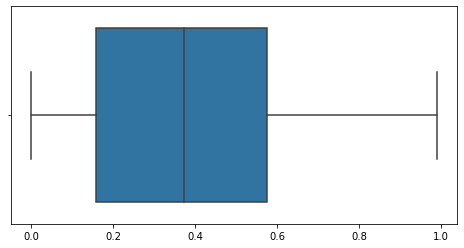

In [33]:
from pmdarima.arima.stationarity import ADFTest

def adf_test(y):
    adf_test = ADFTest(alpha=0.05)
    try :
        p_val, should_diff = adf_test.should_diff(y)
    except:
        # 막히는 경우 ,자료가 부족해서 p_val=0 으로 했다.
        # p_val=0 이라는 뜻은 통계값보다 더 큰 값이 나올 확률이 0이라는 것이다.
        # 즉, 통계를 할 만큼 샘플링 할 큰 자료가 아니라는 뜻이다
        p_val=0
        pass
    return p_val

adf_p=[]

for i in tqdm(data_month['store_id'].unique()):
    ts=time_series(data_month,i)
    adf_p.append(adf_test(ts))
    
plt.figure(figsize=(8, 4))    
sns.boxplot(adf_p)